In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import json

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve


In [2]:
data_path = 'data/movies'
metadata = pd.read_csv(os.path.join(data_path, 'movies_metadata.csv'), low_memory=False)

def convert_metadata(metadata):
    metadata['release_date'] = pd.to_datetime(metadata['release_date'], errors='coerce')
    metadata['budget'] = pd.to_numeric(metadata['budget'], errors='coerce')
    metadata['revenue'] = pd.to_numeric(metadata['revenue'], errors='coerce')
    metadata['runtime'] = pd.to_numeric(metadata['runtime'], errors='coerce')
    return metadata

metadata = convert_metadata(metadata)

metadata = metadata[pd.notnull(metadata['title'])]
metadata = metadata[pd.notnull(metadata['budget'])]
metadata = metadata[pd.notnull(metadata['revenue'])]
metadata = metadata[pd.notnull(metadata['runtime'])]
metadata = metadata[pd.notnull(metadata['release_date'])]
metadata = metadata[pd.notnull(metadata['overview'])]

metadata['year'] = pd.to_datetime(metadata['release_date'], errors='coerce').dt.year.astype('Int64')
metadata['genre_list'] = metadata['genres'].apply(lambda x: [genre['name'] for genre in ast.literal_eval(x)])
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44435 entries, 0 to 45465
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  44435 non-null  object        
 1   belongs_to_collection  4429 non-null   object        
 2   budget                 44435 non-null  float64       
 3   genres                 44435 non-null  object        
 4   homepage               7749 non-null   object        
 5   id                     44435 non-null  object        
 6   imdb_id                44423 non-null  object        
 7   original_language      44425 non-null  object        
 8   original_title         44435 non-null  object        
 9   overview               44435 non-null  object        
 10  popularity             44435 non-null  object        
 11  poster_path            44128 non-null  object        
 12  production_companies   44435 non-null  object        
 13  p

In [3]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(metadata['genre_list'])
label_classes = mlb.classes_

label_classes
label_list = []
for elem in label_classes:
  label_list.append(elem)

final_genres = MultiLabelBinarizer(classes = label_list) 
y = final_genres.fit_transform(metadata['genre_list'])
final_genres.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

In [4]:
X = metadata['title']
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size = 0.2, random_state = 42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

vectorizer = TfidfVectorizer(stop_words = 'english', lowercase = True)

X_train_vector = vectorizer.fit_transform(X_train)
X_val_vector = vectorizer.transform(X_val)

(35548,) (8887,) (35548, 20) (8887, 20)


In [5]:
def pipeline(model, params = None, cv = 5):
    if params == None:
        model.fit(X_train_vector, y_train)
        return(model, model.predict(X_train_vector), model.predict(X_val_vector))
    else:
        model_cv = GridSearchCV(estimator = model, param_grid = params, cv = cv)
        model_cv.fit(X_train_vector, y_train)
        model = model_cv.best_estimator_
            
        return(model, model.predict(X_train_vector), model.predict(X_val_vector), model_cv)

In [6]:
mlp = MLPClassifier(verbose = True, early_stopping=True, max_iter=20, hidden_layer_sizes=(512))

model, train_preds, val_preds = pipeline(mlp)

Iteration 1, loss = 7.39182624
Validation score: 0.045007
Iteration 2, loss = 5.25266357
Validation score: 0.084669
Iteration 3, loss = 4.56518667
Validation score: 0.108017
Iteration 4, loss = 3.88459315
Validation score: 0.111111
Iteration 5, loss = 3.33934748
Validation score: 0.108579
Iteration 6, loss = 2.93789978
Validation score: 0.106048
Iteration 7, loss = 2.65702594
Validation score: 0.112518
Iteration 8, loss = 2.46096357
Validation score: 0.112799
Iteration 9, loss = 2.31963069
Validation score: 0.099859
Iteration 10, loss = 2.21061602
Validation score: 0.111111
Iteration 11, loss = 2.12233916
Validation score: 0.114205
Iteration 12, loss = 2.04565988
Validation score: 0.098734
Iteration 13, loss = 1.97831353
Validation score: 0.111674
Iteration 14, loss = 1.91678648
Validation score: 0.112518
Iteration 15, loss = 1.85980574
Validation score: 0.109705
Iteration 16, loss = 1.80632015
Validation score: 0.111674
Iteration 17, loss = 1.75574720
Validation score: 0.108298
Iterat

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [7]:
target_names = label_list
training_report = classification_report(y_true=y_train, y_pred=train_preds, target_names=target_names)
validation_report = classification_report(y_true=y_val, y_pred=val_preds, target_names=target_names)
train_accuracy = accuracy_score(y_true=y_train, y_pred=train_preds)
validation_accuracy = accuracy_score(y_true=y_val, y_pred=val_preds)
print("Classification Report - Training:\n", training_report)
print("\nClassification Report - Validation:\n", validation_report)
print("\nAccuracy - Training:", train_accuracy)
print("Accuracy - Validation:", validation_accuracy)

Classification Report - Training:
                  precision    recall  f1-score   support

         Action       0.86      0.69      0.76      5260
      Adventure       0.89      0.62      0.73      2781
      Animation       0.93      0.69      0.79      1530
         Comedy       0.87      0.70      0.78     10254
          Crime       0.84      0.55      0.66      3432
    Documentary       0.91      0.65      0.76      3087
          Drama       0.81      0.84      0.82     15994
         Family       0.90      0.67      0.77      2216
        Fantasy       0.90      0.58      0.71      1850
        Foreign       0.93      0.52      0.67      1311
        History       0.95      0.57      0.71      1090
         Horror       0.86      0.73      0.79      3741
          Music       0.90      0.61      0.73      1274
        Mystery       0.88      0.51      0.65      1975
        Romance       0.83      0.59      0.69      5287
Science Fiction       0.90      0.69      0.78      

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_cla

In [8]:

def predict_genre_probabilities_with_names(title, vectorizer, model, label_classes):
    title_vector = vectorizer.transform([title])
    
    genre_probabilities = model.predict_proba(title_vector)
    
    genre_probabilities_with_names = {label: prob for label, prob in zip(label_classes, genre_probabilities[0])}
    
    sorted_probabilities = sorted(genre_probabilities_with_names.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_probabilities

input_title = "The Haunting of the Hill"
probabilities_sorted = predict_genre_probabilities_with_names(input_title, vectorizer, model, label_classes)

for genre, probability in probabilities_sorted:
    print(f"{genre}: {probability}")

Horror: 0.9614273122473338
Thriller: 0.7878203716028672
Mystery: 0.3597366444056951
Fantasy: 0.12608533458712448
Comedy: 0.054159041568599256
Action: 0.0258692942511117
Family: 0.01929758541766367
Drama: 0.019115665476070798
TV Movie: 0.016196422509610606
Adventure: 0.012194200095649841
Animation: 0.0117637404492946
Western: 0.011353111584973503
Science Fiction: 0.008868989777915816
Documentary: 0.007927647345032034
War: 0.004642484553374119
Foreign: 0.004175925215814857
Crime: 0.0021761262430767393
History: 0.0005446878053325795
Romance: 0.0004474458061745476
Music: 0.0003150174410088661


Text(0, 0.5, 'Accuracy')

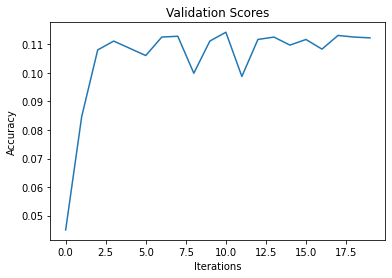

In [9]:
plt.plot(model.validation_scores_)
plt.title('Validation Scores')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Loss')

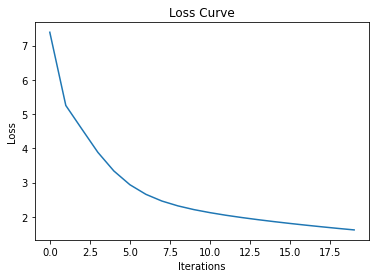

In [10]:
plt.plot(model.loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')

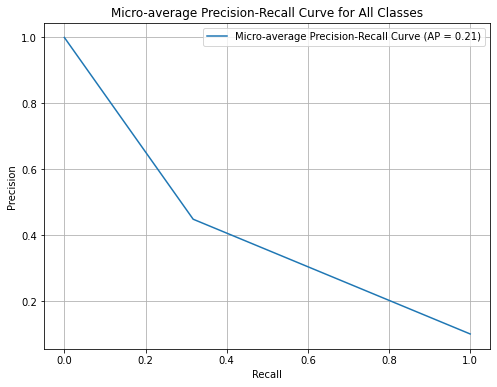

In [11]:
precision, recall, _ = precision_recall_curve(y_val.ravel(), val_preds.ravel())
average_precision = average_precision_score(y_val.ravel(), val_preds.ravel())

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Micro-average Precision-Recall Curve (AP = {:.2f})'.format(average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-average Precision-Recall Curve for All Classes')
plt.legend(loc='best')
plt.grid(True)
plt.show()

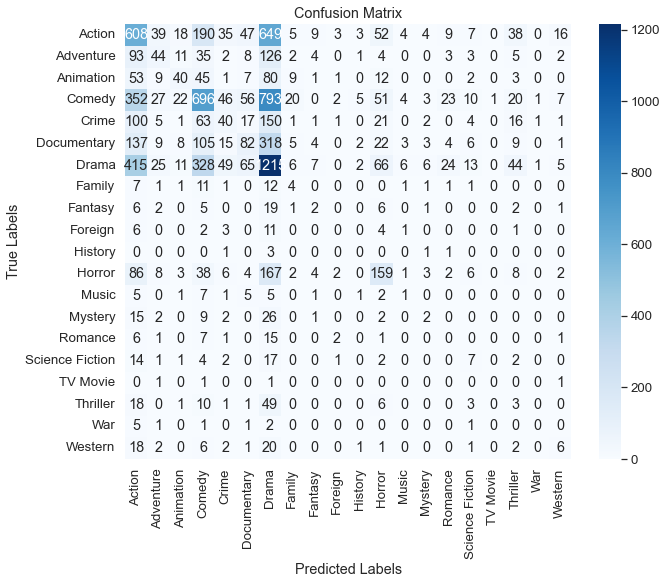

In [12]:
val_preds = model.predict(X_val_vector)

genre_labels = final_genres.classes_

conf_matrix = confusion_matrix(y_val.argmax(axis=1), val_preds.argmax(axis=1))

conf_matrix_df = pd.DataFrame(conf_matrix, index=genre_labels, columns=genre_labels)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('confusion_matrix.png')
plt.show()


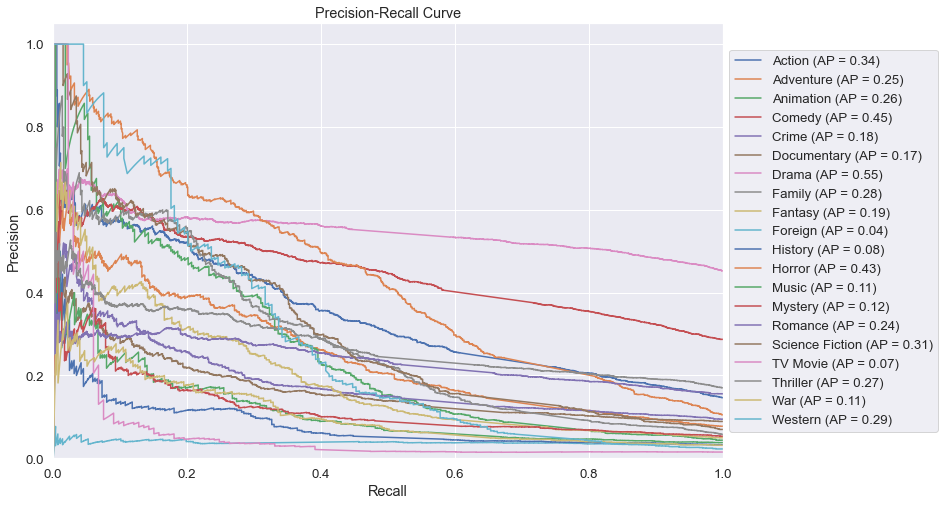

In [13]:
val_preds_proba = model.predict_proba(X_val_vector)

precisions = dict()
recalls = dict()
average_precisions = dict()

for i in range(len(label_list)):
    precisions[i], recalls[i], _ = precision_recall_curve(y_val[:, i], val_preds_proba[:, i])
    average_precisions[i] = average_precision_score(y_val[:, i], val_preds_proba[:, i])

plt.figure(figsize=(12, 8))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')

for i in range(len(label_list)):
    plt.plot(recalls[i], precisions[i], label=f"{label_list[i]} (AP = {average_precisions[i]:0.2f})")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('precision_recall_multiclass.png', bbox_inches='tight')
plt.show()


Iteration 1, loss = 13.61795786
Validation score: 0.010526
Iteration 2, loss = 12.11493391
Validation score: 0.035088
Iteration 3, loss = 9.55901730
Validation score: 0.035088
Iteration 4, loss = 7.07140868
Validation score: 0.035088
Iteration 5, loss = 5.84671617
Validation score: 0.035088
Iteration 6, loss = 5.45257348
Validation score: 0.035088
Iteration 7, loss = 5.23338442
Validation score: 0.045614
Iteration 8, loss = 5.04728626
Validation score: 0.056140
Iteration 9, loss = 4.85508405
Validation score: 0.059649
Iteration 10, loss = 4.64770012
Validation score: 0.063158
Iteration 11, loss = 4.42174808
Validation score: 0.063158
Iteration 12, loss = 4.17817415
Validation score: 0.066667
Iteration 13, loss = 3.91987968
Validation score: 0.066667
Iteration 14, loss = 3.65120766
Validation score: 0.063158
Iteration 15, loss = 3.37983631
Validation score: 0.066667
Iteration 16, loss = 3.11380026
Validation score: 0.073684
Iteration 17, loss = 2.85820595
Validation score: 0.073684
Iter

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 11.73990845
Validation score: 0.054054
Iteration 2, loss = 6.24153545
Validation score: 0.054054
Iteration 3, loss = 5.46780132
Validation score: 0.052973
Iteration 4, loss = 5.18304025
Validation score: 0.069189
Iteration 5, loss = 4.80727650
Validation score: 0.076757
Iteration 6, loss = 4.33199740
Validation score: 0.075676
Iteration 7, loss = 3.82909291
Validation score: 0.073514
Iteration 8, loss = 3.35745596
Validation score: 0.080000
Iteration 9, loss = 2.94293465
Validation score: 0.086486
Iteration 10, loss = 2.58973076
Validation score: 0.080000
Iteration 11, loss = 2.29219910
Validation score: 0.083243
Iteration 12, loss = 2.04497698
Validation score: 0.086486
Iteration 13, loss = 1.84333405
Validation score: 0.087568
Iteration 14, loss = 1.68096964
Validation score: 0.084324
Iteration 15, loss = 1.54717349
Validation score: 0.081081
Iteration 16, loss = 1.44002383
Validation score: 0.085405
Iteration 17, loss = 1.34974563
Validation score: 0.081081
Itera

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 9.41324695
Validation score: 0.045396
Iteration 2, loss = 5.57319886
Validation score: 0.055627
Iteration 3, loss = 5.23348737
Validation score: 0.072251
Iteration 4, loss = 4.77884353
Validation score: 0.083120
Iteration 5, loss = 4.19300156
Validation score: 0.089514
Iteration 6, loss = 3.60582583
Validation score: 0.096547
Iteration 7, loss = 3.09674434
Validation score: 0.093990
Iteration 8, loss = 2.68561544
Validation score: 0.093990
Iteration 9, loss = 2.36342272
Validation score: 0.093350
Iteration 10, loss = 2.11700809
Validation score: 0.104220
Iteration 11, loss = 1.93156813
Validation score: 0.088235
Iteration 12, loss = 1.78611395
Validation score: 0.088875
Iteration 13, loss = 1.67411941
Validation score: 0.098465
Iteration 14, loss = 1.58174147
Validation score: 0.102941
Iteration 15, loss = 1.50661344
Validation score: 0.089514
Iteration 16, loss = 1.44336202
Validation score: 0.101023
Iteration 17, loss = 1.38915697
Validation score: 0.101662
Iterat

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 8.43601147
Validation score: 0.044465
Iteration 2, loss = 5.46353053
Validation score: 0.069873
Iteration 3, loss = 5.00527682
Validation score: 0.085753
Iteration 4, loss = 4.38575361
Validation score: 0.099365
Iteration 5, loss = 3.75862805
Validation score: 0.103448
Iteration 6, loss = 3.22879921
Validation score: 0.107532
Iteration 7, loss = 2.81435399
Validation score: 0.105717
Iteration 8, loss = 2.50048231
Validation score: 0.106171
Iteration 9, loss = 2.26517552
Validation score: 0.101633
Iteration 10, loss = 2.08828193
Validation score: 0.107985
Iteration 11, loss = 1.95589518
Validation score: 0.112976
Iteration 12, loss = 1.84632507
Validation score: 0.106171
Iteration 13, loss = 1.76012573
Validation score: 0.111162
Iteration 14, loss = 1.68328323
Validation score: 0.107985
Iteration 15, loss = 1.61915532
Validation score: 0.107078
Iteration 16, loss = 1.56127387
Validation score: 0.104356
Iteration 17, loss = 1.50955813
Validation score: 0.106171
Iterat

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 7.88949995
Validation score: 0.049578
Iteration 2, loss = 5.40565501
Validation score: 0.078059
Iteration 3, loss = 4.83377431
Validation score: 0.106892
Iteration 4, loss = 4.14994937
Validation score: 0.109001
Iteration 5, loss = 3.54037839
Validation score: 0.112166
Iteration 6, loss = 3.06162568
Validation score: 0.115331
Iteration 7, loss = 2.70753917
Validation score: 0.119902
Iteration 8, loss = 2.45426449
Validation score: 0.112869
Iteration 9, loss = 2.27092186
Validation score: 0.123066
Iteration 10, loss = 2.13326555
Validation score: 0.110759
Iteration 11, loss = 2.02513343
Validation score: 0.117792
Iteration 12, loss = 1.93565091
Validation score: 0.117792
Iteration 13, loss = 1.85864190
Validation score: 0.104079
Iteration 14, loss = 1.78974073
Validation score: 0.116385
Iteration 15, loss = 1.72831206
Validation score: 0.117440
Iteration 16, loss = 1.67219804
Validation score: 0.102321
Iteration 17, loss = 1.61852366
Validation score: 0.115682
Iterat

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 11.68298485
Validation score: 0.037838
Iteration 2, loss = 6.23611810
Validation score: 0.037838
Iteration 3, loss = 5.52060707
Validation score: 0.056216
Iteration 4, loss = 5.24843974
Validation score: 0.070270
Iteration 5, loss = 4.89031284
Validation score: 0.076757
Iteration 6, loss = 4.43057132
Validation score: 0.096216
Iteration 7, loss = 3.93083963
Validation score: 0.094054
Iteration 8, loss = 3.45413712
Validation score: 0.099459
Iteration 9, loss = 3.02912326
Validation score: 0.097297
Iteration 10, loss = 2.66654153
Validation score: 0.089730
Iteration 11, loss = 2.35689622
Validation score: 0.092973
Iteration 12, loss = 2.10111378
Validation score: 0.088649
Iteration 13, loss = 1.88946695
Validation score: 0.085405
Iteration 14, loss = 1.71673147
Validation score: 0.083243
Iteration 15, loss = 1.57562843
Validation score: 0.082162
Iteration 16, loss = 1.45916011
Validation score: 0.080000
Iteration 17, loss = 1.36303211
Validation score: 0.078919
Itera

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 11.62086654
Validation score: 0.050811
Iteration 2, loss = 6.23537342
Validation score: 0.050811
Iteration 3, loss = 5.52103898
Validation score: 0.054054
Iteration 4, loss = 5.24746030
Validation score: 0.069189
Iteration 5, loss = 4.88262999
Validation score: 0.078919
Iteration 6, loss = 4.41737254
Validation score: 0.088649
Iteration 7, loss = 3.91656230
Validation score: 0.095135
Iteration 8, loss = 3.43329734
Validation score: 0.091892
Iteration 9, loss = 2.99660467
Validation score: 0.087568
Iteration 10, loss = 2.62254043
Validation score: 0.088649
Iteration 11, loss = 2.30987293
Validation score: 0.086486
Iteration 12, loss = 2.05235689
Validation score: 0.088649
Iteration 13, loss = 1.83996461
Validation score: 0.082162
Iteration 14, loss = 1.66892070
Validation score: 0.086486
Iteration 15, loss = 1.52917558
Validation score: 0.087568
Iteration 16, loss = 1.41299560
Validation score: 0.085405
Iteration 17, loss = 1.31977176
Validation score: 0.084324
Itera

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 11.82132286
Validation score: 0.044324
Iteration 2, loss = 6.28987337
Validation score: 0.044324
Iteration 3, loss = 5.51236474
Validation score: 0.045405
Iteration 4, loss = 5.22130206
Validation score: 0.050811
Iteration 5, loss = 4.84576612
Validation score: 0.072432
Iteration 6, loss = 4.37866541
Validation score: 0.088649
Iteration 7, loss = 3.87442909
Validation score: 0.088649
Iteration 8, loss = 3.39425009
Validation score: 0.091892
Iteration 9, loss = 2.96880993
Validation score: 0.094054
Iteration 10, loss = 2.60561035
Validation score: 0.096216
Iteration 11, loss = 2.30212317
Validation score: 0.094054
Iteration 12, loss = 2.04890583
Validation score: 0.090811
Iteration 13, loss = 1.84253708
Validation score: 0.088649
Iteration 14, loss = 1.67504253
Validation score: 0.087568
Iteration 15, loss = 1.53749876
Validation score: 0.088649
Iteration 16, loss = 1.42614877
Validation score: 0.086486
Iteration 17, loss = 1.33353163
Validation score: 0.086486
Itera

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 9.47674833
Validation score: 0.042199
Iteration 2, loss = 5.60286833
Validation score: 0.042199
Iteration 3, loss = 5.27169840
Validation score: 0.056266
Iteration 4, loss = 4.81963333
Validation score: 0.082481
Iteration 5, loss = 4.23372742
Validation score: 0.091432
Iteration 6, loss = 3.65447275
Validation score: 0.093350
Iteration 7, loss = 3.16126539
Validation score: 0.095908
Iteration 8, loss = 2.75666549
Validation score: 0.096547
Iteration 9, loss = 2.43374236
Validation score: 0.102302
Iteration 10, loss = 2.17856575
Validation score: 0.098465
Iteration 11, loss = 1.97962460
Validation score: 0.095269
Iteration 12, loss = 1.82479864
Validation score: 0.106138
Iteration 13, loss = 1.70188077
Validation score: 0.107417
Iteration 14, loss = 1.60269120
Validation score: 0.097826
Iteration 15, loss = 1.51841853
Validation score: 0.095269
Iteration 16, loss = 1.44861697
Validation score: 0.106777
Iteration 17, loss = 1.38947682
Validation score: 0.106777
Iterat

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 8.51660924
Validation score: 0.045826
Iteration 2, loss = 5.48356528
Validation score: 0.063521
Iteration 3, loss = 5.04140645
Validation score: 0.085753
Iteration 4, loss = 4.42073138
Validation score: 0.094828
Iteration 5, loss = 3.78968189
Validation score: 0.100726
Iteration 6, loss = 3.25401575
Validation score: 0.102541
Iteration 7, loss = 2.83129368
Validation score: 0.106171
Iteration 8, loss = 2.50768527
Validation score: 0.111162
Iteration 9, loss = 2.26643180
Validation score: 0.103902
Iteration 10, loss = 2.08653544
Validation score: 0.106624
Iteration 11, loss = 1.94964059
Validation score: 0.105717
Iteration 12, loss = 1.84165033
Validation score: 0.097550
Iteration 13, loss = 1.75233815
Validation score: 0.098911
Iteration 14, loss = 1.67793701
Validation score: 0.104356
Iteration 15, loss = 1.61136304
Validation score: 0.106171
Iteration 16, loss = 1.55419422
Validation score: 0.107532
Iteration 17, loss = 1.50234219
Validation score: 0.105263
Iterat

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 11.78396508
Validation score: 0.042162
Iteration 2, loss = 6.29571885
Validation score: 0.042162
Iteration 3, loss = 5.50732188
Validation score: 0.043243
Iteration 4, loss = 5.22286921
Validation score: 0.059459
Iteration 5, loss = 4.86435456
Validation score: 0.076757
Iteration 6, loss = 4.41041718
Validation score: 0.090811
Iteration 7, loss = 3.91056203
Validation score: 0.091892
Iteration 8, loss = 3.43155468
Validation score: 0.094054
Iteration 9, loss = 3.00613546
Validation score: 0.094054
Iteration 10, loss = 2.64326191
Validation score: 0.085405
Iteration 11, loss = 2.33632502
Validation score: 0.081081
Iteration 12, loss = 2.08260620
Validation score: 0.082162
Iteration 13, loss = 1.87371370
Validation score: 0.076757
Iteration 14, loss = 1.70081042
Validation score: 0.076757
Iteration 15, loss = 1.55950699
Validation score: 0.076757
Iteration 16, loss = 1.44192671
Validation score: 0.077838
Iteration 17, loss = 1.34488129
Validation score: 0.077838
Itera

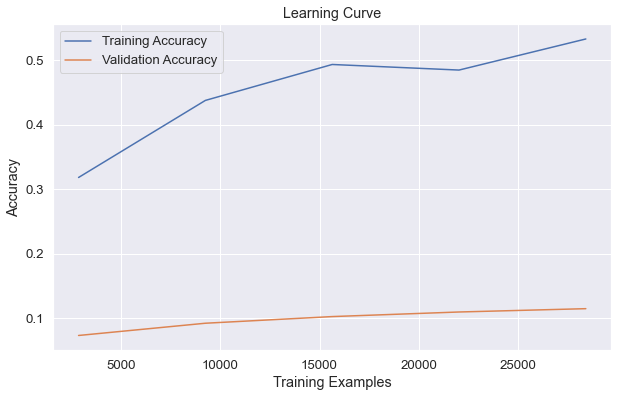

In [14]:
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train_vector, y_train, cv=5, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.savefig('learning_curve.png')
plt.show()